## Example to use the different algorithms

In [14]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import logging
from copy import deepcopy
import numpy as np
import random

from spacebench import SpaceEnv
from spacebench import algorithms

# configure logging to print time
logging.basicConfig(
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

# np.random.seed(3)å
# random.seed(3)

In [15]:
env_name = "climate_relhum_wfsmoke_cont"
env = SpaceEnv(env_name, dir="downloads")

# randomly mask a covariate group to induce spatial confounding
# dataset = env.make(missing_group="cs_population_density")
dataset = env.make()
dataset_full = dataset.unmask()

tmin = np.quantile(dataset.treatment, 0.025)
tmax = np.quantile(dataset.treatment, 0.975)
# dataset = dataset[(dataset.treatment > tmin) & (dataset.treatment < tmax)]
# dataset_full = dataset_full[(dataset_full.treatment > tmin) & (dataset_full.treatment < tmax)]

# mask even further for visualization/demo purposes
# dataset.covariates = dataset.covariates[:, :8]

logging.info(f"Masked model covariates shape: {dataset.covariates.shape}")
logging.info(f"Full model covariates shape: {dataset_full.covariates.shape}")

# print confounding score
logging.info(f"Confounding score: {dataset.confounding_score}")

18:42:53 DEBUG Missing covariate group (selected at random): poverty
18:42:53 INFO Masked model covariates shape: (8616, 14)
18:42:53 INFO Full model covariates shape: (8616, 17)
18:42:53 INFO Confounding score: {'erf': 0.23180703818798065, 'ate': nan, 'ite': 0.5167921185493469, 'importance': 0.002502416432017438}


In [16]:
# init models
models = {
    "OLS": algorithms.OLS(),
    # "XGBoost": algorithms.XGBoost(n_estimators=50, learning_rate=0.25, max_depth=2),
    # "MLPSpatial": algorithms.MLPSpatial(max_iter=2_500, dropout=0.01)
    "GNN": algorithms.GCN(epochs=1000, dropout=0.1, verbose=False),
    "DRNet": algorithms.DrnetSpatial(max_iter=1000, dropout=0.1, n_cutpoints=4),
}
# make to store the solutions without missing confounders
models_full = deepcopy(models)

# fit all models
for name, model in models.items():
    logging.info(f"Fitting {name}...")
    model.fit(dataset)

# fit all models on the full dataset
for name, model in models_full.items():
    logging.info(f"Fitting {name} on full dataset...")
    model.fit(dataset_full)   

18:42:53 INFO Fitting OLS...
18:42:53 INFO Fitting GNN...
18:42:53 DEBUG Building GCN model...
18:42:53 DEBUG Preparing torch geometric data loader...
18:42:53 DEBUG Preparing trainer...
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
18:42:53 DEBUG Training GCN model...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.007079457843841375
Restoring states from the checkpoint path at /Users/mag7273/Github/space_58/.lr_find_d5b5ed35-8916-4876-a7a4-a448318ee028.ckpt
Restored all states from the checkpoint at /Users/mag7273/Github/space_58/.lr_find_d5b5ed35-8916-4876-a7a4-a448318ee028.ckpt
Restored all states from the checkpoint at /Users/mag7273/Github/space_58/.lr_find_d5b5ed35-8916-4876-a7a4-a448318ee028.ckpt
`Trainer.fit` stopped: `max_epochs=1000` reached.
18:43:08 DEBUG Finished training GCN model.
18:43:08 INFO Fitting DRNet...
18:43:23 INFO Fitting OLS on full dataset...
18:43:23 INFO Fitting GNN on full dataset...
18:43:23 DEBUG Building GCN model...
18:43:23 DEBUG Preparing torch geometric data loader...
18:43:23 DEBUG Preparing trainer...
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
18:43:23 DEBUG Training GCN model...


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0022387211385683386
Restoring states from the checkpoint path at /Users/mag7273/Github/space_58/.lr_find_82802baf-a3d4-4029-8d04-231777d14dd3.ckpt
Restored all states from the checkpoint at /Users/mag7273/Github/space_58/.lr_find_82802baf-a3d4-4029-8d04-231777d14dd3.ckpt
Restored all states from the checkpoint at /Users/mag7273/Github/space_58/.lr_find_82802baf-a3d4-4029-8d04-231777d14dd3.ckpt
`Trainer.fit` stopped: `max_epochs=1000` reached.
18:43:39 DEBUG Finished training GCN model.
18:43:39 INFO Fitting DRNet on full dataset...


In [17]:
# estimate causal effects
preds = {}
preds_full = {}

for name, model in models.items():
    logging.info(f"Predicting {name}...")
    preds[name] = model.eval(dataset)

for name, model in models_full.items():
    logging.info(f"Predicting {name} on full dataset...")
    preds_full[name] = model.eval(dataset_full)

18:43:54 INFO Predicting OLS...
18:43:54 INFO Predicting GNN...
18:43:54 DEBUG Preparing torch geometric data loader with existing scaler...
18:43:54 DEBUG Computing counterfactuals...
18:43:55 INFO Predicting DRNet...
18:43:56 INFO Predicting OLS on full dataset...
18:43:56 INFO Predicting GNN on full dataset...
18:43:56 DEBUG Preparing torch geometric data loader with existing scaler...
18:43:56 DEBUG Computing counterfactuals...
18:43:58 INFO Predicting DRNet on full dataset...


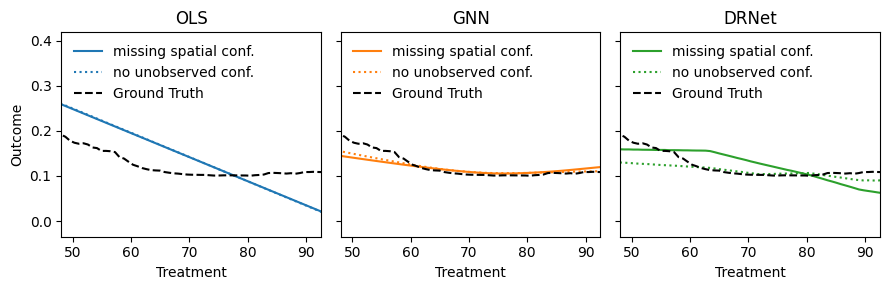

In [18]:
pal = plt.get_cmap("tab10")

treatment_values = dataset.treatment_values
# ground_truth = np.quantile(dataset.counterfactuals, 0.5, axis=0)
ground_truth = dataset.counterfactuals.mean(axis=0)

K = len(preds)
fig, ax = plt.subplots(1, K, figsize=(3 * K, 3), sharey=True, sharex=True)
for i, (name, values) in enumerate(preds.items()):
    ax[i].plot(treatment_values, values["erf"], label="missing spatial conf.", c=pal(i))
    pass

for i, (name, values) in enumerate(preds_full.items()):
    ax[i].plot(treatment_values, values["erf"], label="no unobserved conf.", linestyle=":", c=pal(i))
    ax[i].plot(treatment_values, ground_truth, label="Ground Truth", linestyle="--", c="k")
    ax[i].legend(loc="upper left", frameon=False)
    ax[i].set_xlabel("Treatment")
    ax[i].set_title(name)
    if i == 0:
        ax[i].set_ylabel("Outcome")
    ax[i].set_xlim([tmin, tmax])

# reduce space
plt.tight_layout()
plt.savefig("examples/figures/example_fit.png", dpi=300)